2025/12/11
By Li.Jiahao
After learning the Deutsch Algorithm, we might think that quantum algorithm just saves the half query times which looks doesn't like a outstanding skill.So this section will reveal a new stuation that applies to multiple input bits.

# Deutsch-Jozsa Algorithm

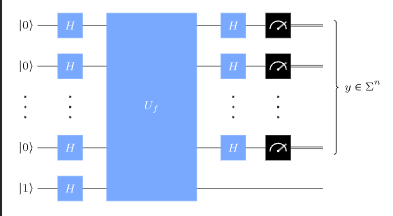